# Eikonal equation on N-dimensional graphs

Given an bounded domain $\Omega \subset \mathbb{R}^d$ ($d\geq 2$) we are interested to solve, 
\begin{align}
|\nabla u(x)| &= f(x) = 0, &&  x \in \Omega\\
u(x) &= 0, && x \in \partial \Omega
\end{align}

## Importing libraries

In [1]:
import os
os.chdir('../')
!bash compile.sh

running build_ext
gcc -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include -arch x86_64 -I/Users/wonjunlee/miniconda3/envs/cv/include/python3.6m -c flagcheck.cpp -o flagcheck.o -std=c++17
copying build/lib.macosx-10.9-x86_64-3.6/MonotoneScheme.cpython-36m-darwin.so -> 


In [1]:
import os
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy import sparse
from monotonescheme import EikonalGraph

# make folder if not exists
save_fig_path = 'figures'
if not os.path.exists(save_fig_path):
    os.makedirs(save_fig_path)
save_data_path = 'data'
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

## Generating data samples

In [43]:
n = 5000 # number of points
dim = 2 # dimensions

def generate_random_point_cloud_unit_square(n, dim=2, k=20):
    X = np.random.rand(n, dim)
    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W
def generate_random_point_cloud_circle(n, dim=2, k=20):
    X = [[0.5]*dim]
    count = 1
    R = 0.4
    while count < n:
        z = np.random.rand(dim)
        if  np.sum((z-0.5)**2)  <= R**2:
            X.append(z)
            count += 1
    X = np.array(X)

    W = gl.weightmatrix.knn(X,k,kernel='distance')
    return X, W

def process_sparse_data(X, W):
    #Coordinates of sparse matrix for passing to C code
    I,J,V = sparse.find(W)
    K = np.array((J[1:] - J[:-1]).nonzero()) + 1
    K = np.append(0,np.append(K,len(J)))
    X = np.ascontiguousarray(X, np.float64)
    V = np.ascontiguousarray(V, np.float64)
    I = np.ascontiguousarray(I, np.int32)
    K = np.ascontiguousarray(K, np.int32)
    print(X.shape, V.shape, K.shape, I.shape)
    return X,V,I,K

X, W = generate_random_point_cloud_circle(n,dim,30) # first param: number of points # second param: number of neighbord points
mask    = (np.sum((X-0.5)**2,axis=1) > 0.36**2)
bdy_pts = np.arange(n)[mask]

# X, W = generate_random_point_cloud_unit_square(n,dim,30)
# mask    = (np.prod(np.abs(X-0.5)<0.45, axis=1) == False)
# bdy_pts = np.arange(n)[mask]

X,V,I,K = process_sparse_data(X,W)

print("data samples generated.")

(5000, 2) (158712,) (5001,) (158712,)
data samples generated.


## Initialize PDE solver

In [44]:
f = np.ones((n))
u = np.zeros((n))
max_it = 100
tol    = 1e-5
solver = EikonalGraph(X, V, I, K, f, bdy_pts)

interior: 4067 threads:  12 count: 2166083


### Running the algorithm

In [45]:
t = tqdm.tqdm(range(max_it), position=0)
for i in t:
    error = solver.iterate(u)
    t.set_description_str(f'Error: {error:0.2e}')
    if error < tol:
        break
print(f"Took {t.format_dict['elapsed']:0.2f} seconds to complete.")

Error: 8.86e-03:   0%|          | 0/100 [00:00<?, ?it/s]

Error: 6.22e-06:  33%|███▎      | 33/100 [00:00<00:00, 68.29it/s]

Took 0.48 seconds to complete.


### Plotting the result

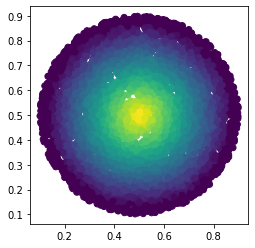

In [46]:
fig, ax = plt.subplots(1,1)
im = ax.scatter(X[:,0], X[:,1], c=u)
ax.set_aspect('equal')
plt.show()